# Report 3

### by Kaitlyn Keil and Kevin Zhang
### April 2017

<a href = http://tna.europarchive.org/20110116113217/http:/www.food.gov.uk/science/dietarysurveys/dietsurveys/>UK Food Network Dataset</a>

http://tna.europarchive.org/20110116113217/http://www.food.gov.uk/multimedia/pdfs/cofuserdoc.pdf

In [1]:
""" This file contains code used to analyze the
UK Food Nutrient Database, the information for which can be found
at this link: http://tna.europarchive.org/20110116113217/http:/www.food.gov.uk/science/dietarysurveys/dietsurveys/

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
import seaborn as sns

from collections import defaultdict, Counter
import statsmodels.formula.api as smf

In [2]:
def ReadProximates():
    df = pd.read_excel('dietary.xls', sheetname='Proximates')
    column_list = ['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
    
    df['Water'] = pd.to_numeric(df['Water (g)'], errors='coerce')
    df['Protein'] = pd.to_numeric(df['Protein (g)'], errors='coerce')
    df['Fat'] = pd.to_numeric(df['Fat (g)'], errors='coerce')
    df['Carbohydrate'] = pd.to_numeric(df['Carbohydrate (g)'], errors='coerce')
    df['Sugars'] = pd.to_numeric(df['Total sugars (g)'], errors='coerce')
    
    df['Water'].replace([np.nan], 0, inplace=True)
    df['Protein'].replace([np.nan], 0, inplace=True)
    df['Fat'].replace([np.nan], 0, inplace=True)
    df['Carbohydrate'].replace([np.nan], 0, inplace=True)
    df['Sugars'].replace([np.nan], 0, inplace=True)
    
    
#     for column in column_list:
#         new_name = column[:-4]
#         df[new_name]= df[column]
#         for key, value in df[column].items():
#             if isinstance(value, str):
#                 if '(' in value:
#                     df[new_name][key] = float(value[1:-1])
#                 elif value=='Tr':
#                     df[new_name][key] = 0.0
#                 elif value=='N':
#                     df[new_name][key] = 0.0
#                 elif math.isnan(float(value)):
#                     df[new_name][key] = 0.0
#                     print('NaN found')
#                 else:
#                     df[new_name][key] = float(value)
        
    return df

In [3]:
#tester = pd.read_excel('dietary.xls', sheetname='Proximates')
# tester = ReadProximates()
# TO DO
# For cleaning: 
#  Get rid of Ns and Trs <- Done!
#  Figure out how to deal with parentheses <- Done!
#  Convert rows into floats (.astype) <- Done!
#  Get ready for lots of brackets...
#  Potentially just make different columns for the integer values <- ...done?

# For report:
#  Figure out if we can actually classify based on these values
#  Make a dictionary mapping from the Group codes to actual names
#  Figure out a good model
#  Do the thing
#  PCA to figure out the components we will want to look at
#  Unclassified ML to figure out natural groups?


In [4]:
tester = ReadProximates()

In [5]:
from sklearn.cluster import KMeans
#['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
water = pd.Series(tester.Water, name='Water')
protein = pd.Series(tester.Protein, name='Protein')
fat = pd.Series(tester.Fat, name='Fat')
carbs = pd.Series(tester.Carbohydrate, name='Carbs')
sugars = pd.Series(tester['Sugars'], name='Sugars')
X = pd.concat([water,protein,fat,carbs,sugars], axis=1)
X.fillna(0)
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans.fit(X.dropna())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [6]:
# Try log or logit scale
# pairwise, maybe look at PCA

In [7]:
x_vals = 'Protein'
y_vals = 'Carbohydrate'
z_vals = 'Fat'

food_group_dict = {'A':['Cereals','peru'], 'B':['Dairy','beige'], 'C':['Egg','paleturquoise'],
                  'D':['Vegetable','darkolivegreen'], 'F':['Fruit','firebrick'], 'G':['Nuts','saddlebrown'],
                  'J':['Fish','slategray'],'M':['Meat','indianred'], 'O':['Fat','khaki']}

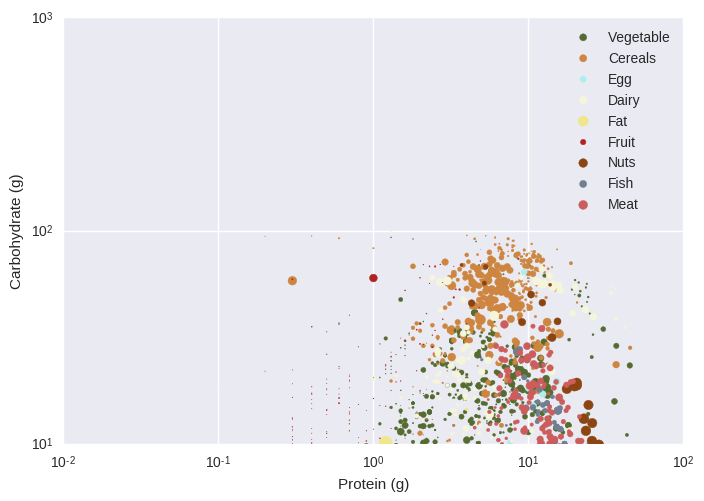

In [8]:
ax = plt.subplot(111)
for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter(df[x_vals],df[y_vals],df[z_vals],color=val[1],label = val[0])
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel(x_vals+' (g)')  
ax.set_ylabel(y_vals+' (g)')
#ax.set_zlabel(z_vals+' (g)')
ax.legend()

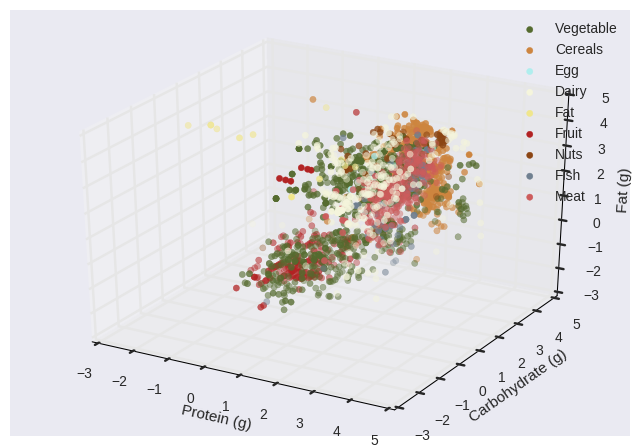

In [9]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
#ax.scatter3D(tester[x_vals], tester[y_vals], tester[z_vals])

for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter3D(np.log(df[x_vals]),np.log(df[y_vals]),np.log(df[z_vals]),color=val[1],label = val[0])
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(x_vals+' (g)')  
ax.set_ylabel(y_vals+' (g)')
ax.set_zlabel(z_vals+' (g)')
ax.legend()

In [10]:
def ThreeDPlot(pred_cat, actual_cat, ax, actual_label, colors = ['firebrick', 'peru']):
    ax.scatter3D(np.log(pred_cat.Protein),np.log(pred_cat.Carbs), np.log(pred_cat.Fat), c = colors[0], label = 'Predicted Group')
    ax.scatter3D(np.log(actual_cat.Protein),np.log(actual_cat.Carbohydrate), np.log(actual_cat.Fat), c = colors[1], label = actual_label, alpha= .5)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

In [11]:
cereals = tester[tester.Group.str.startswith('A', na=False)]
cereals['Label'] = cereals.Water*0+5

fruits = tester[tester.Group.str.startswith('F', na=False)]
fruits['Label'] = fruits.Water*0+3

veggies = tester[tester.Group.str.startswith('D', na=False)]
veggies['Label'] = veggies.Water*0+0

dairy = tester[tester.Group.str.startswith('B', na=False)]
dairy['Label'] = dairy.Water*0+2

oils = tester[tester.Group.str.startswith('O', na=False)]
oils['Label'] = oils.Water*0+4

m1 = tester[tester.Group.str.startswith('J', na=False)]
m2 = tester[tester.Group.str.startswith('M', na=False)]
meats = pd.concat([m1,m2])
meats['Label'] = meats.Water*0+1

all_these = pd.concat([cereals, fruits, veggies, dairy, oils, meats])


/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

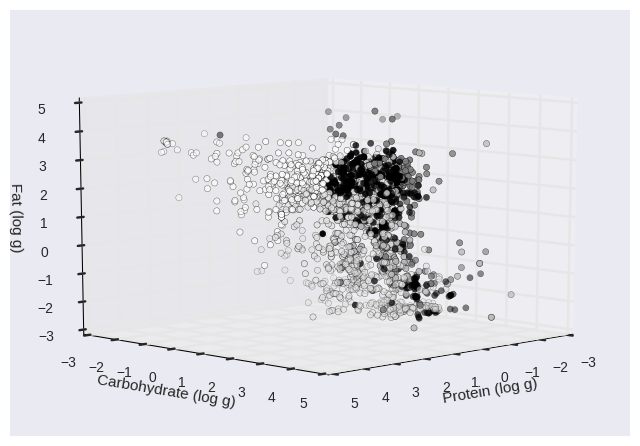

In [12]:
from sklearn.cluster import KMeans
#['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
water = pd.Series(all_these.Water, name='Water')
protein = pd.Series(all_these.Protein, name='Protein')
fat = pd.Series(all_these.Fat, name='Fat')
carbs = pd.Series(all_these.Carbohydrate, name='Carbs')
sugars = pd.Series(all_these['Sugars'], name='Sugars')
X = pd.concat([protein,fat,carbs,sugars], axis=1)
X.fillna(0)
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X.dropna())
y_kmeans = kmeans.predict(X)

ax = plt.subplot(projection='3d')

ax.scatter3D(np.log(X.Protein),np.log(X.Carbs), np.log(X.Fat), c = y_kmeans)
ax.view_init(elev=10, azim=45)
    
ax.set_xlabel('Protein (log g)')
ax.set_ylabel('Carbohydrate (log g)')
ax.set_zlabel('Fat (log g)')

In [13]:
predicted_labels = pd.DataFrame(y_kmeans).astype(float)
X['predictions'] = predicted_labels

In [14]:
labeled0 = X[X.predictions == 0]
labeled1 = X[X.predictions == 1]
labeled2 = X[X.predictions == 2]
labeled3 = X[X.predictions == 3]
labeled4 = X[X.predictions == 4]
labeled5 = X[X.predictions == 5]

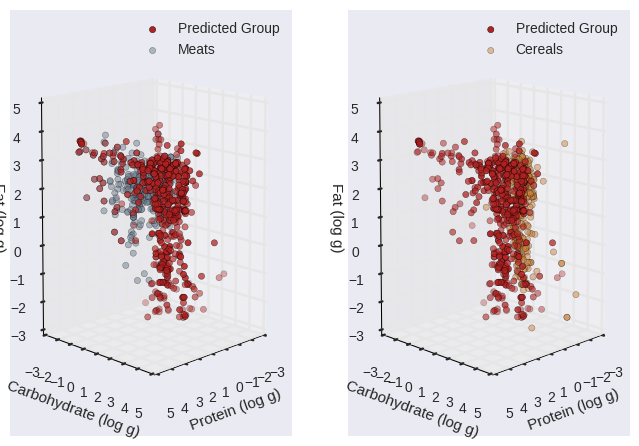

In [15]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

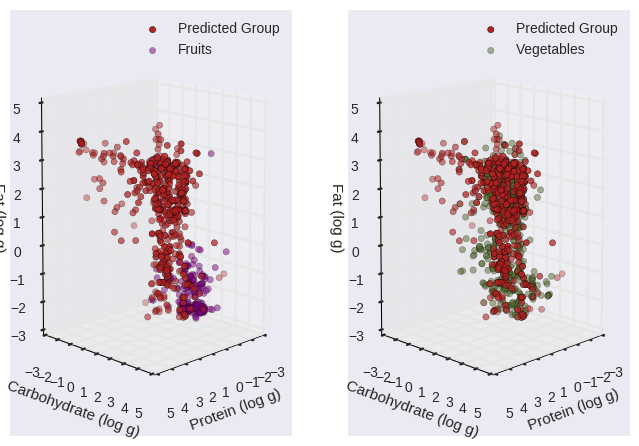

In [16]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

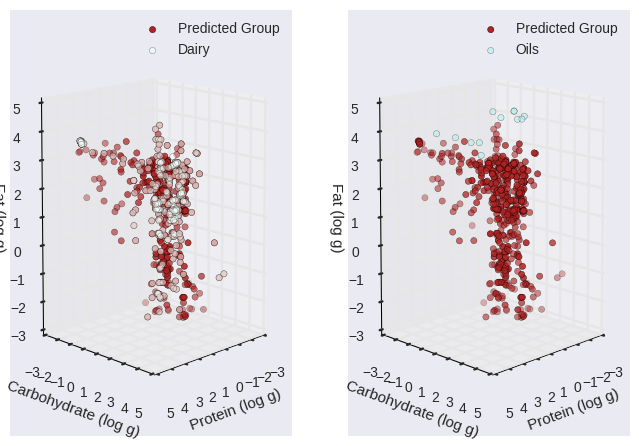

In [17]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

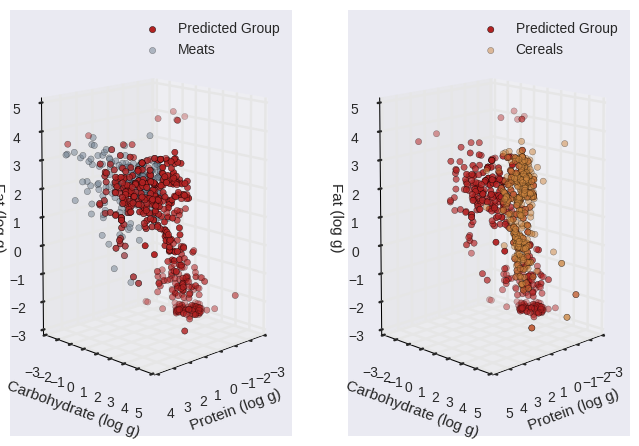

In [18]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

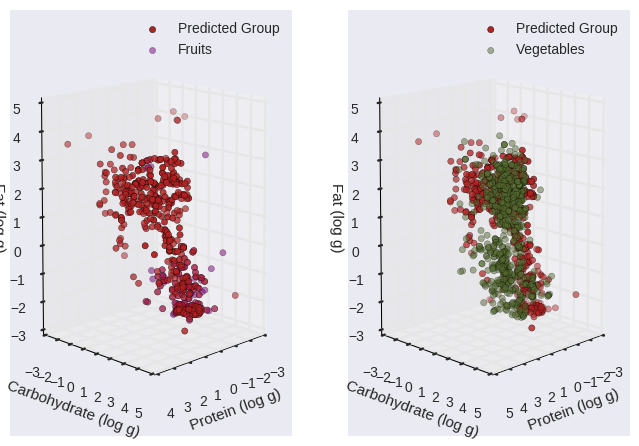

In [19]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

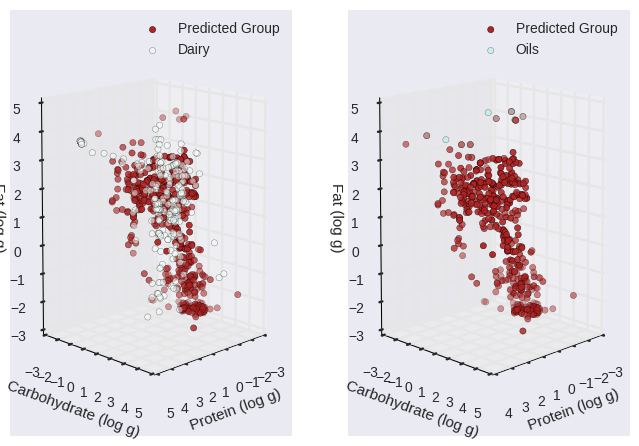

In [20]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

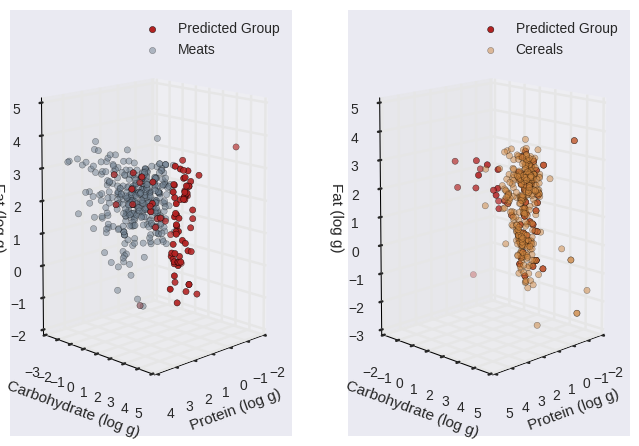

In [21]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

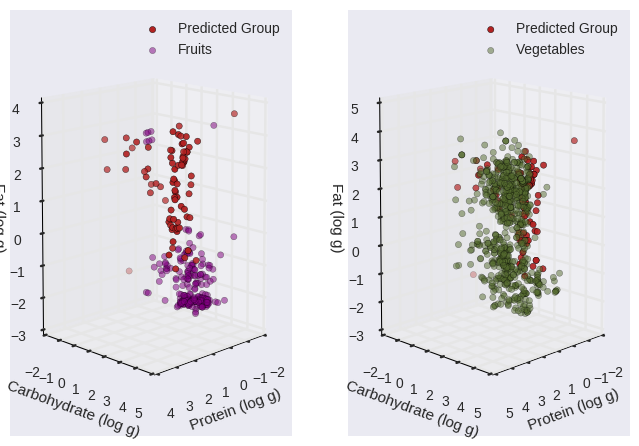

In [22]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

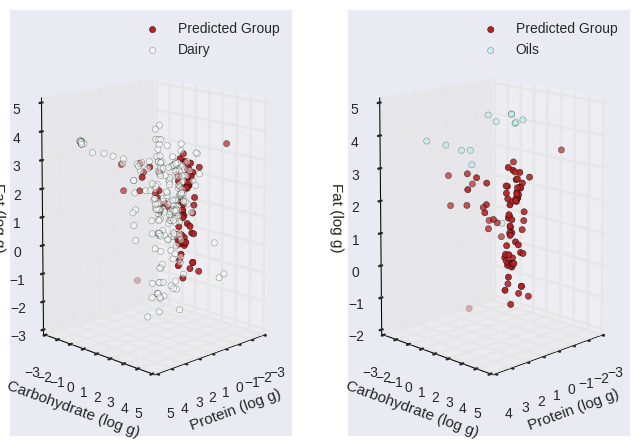

In [23]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

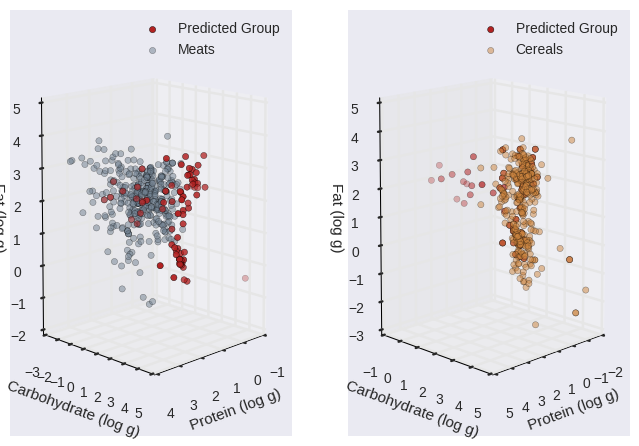

In [24]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

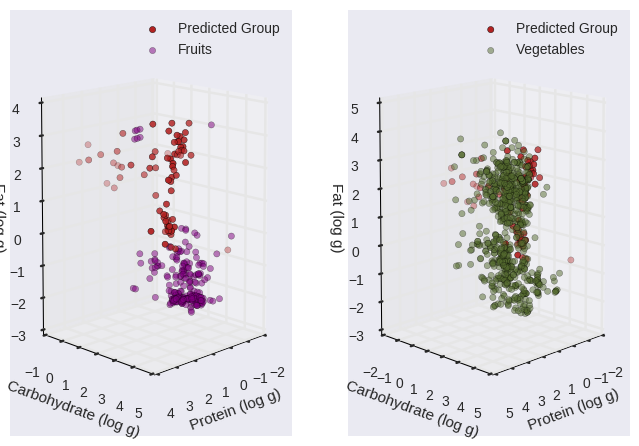

In [25]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

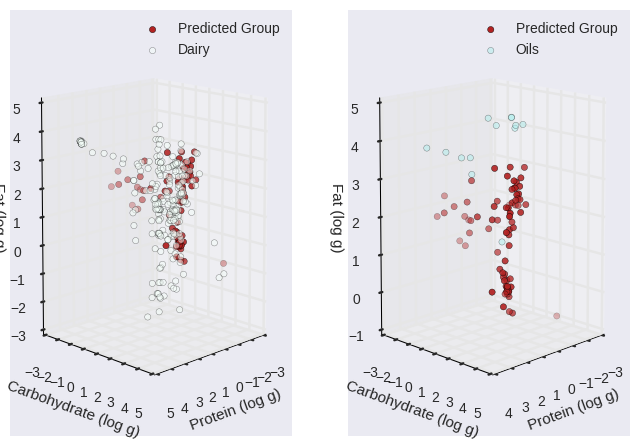

In [26]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

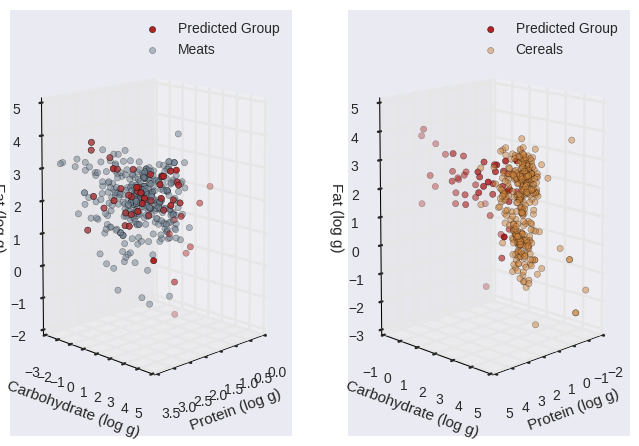

In [27]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

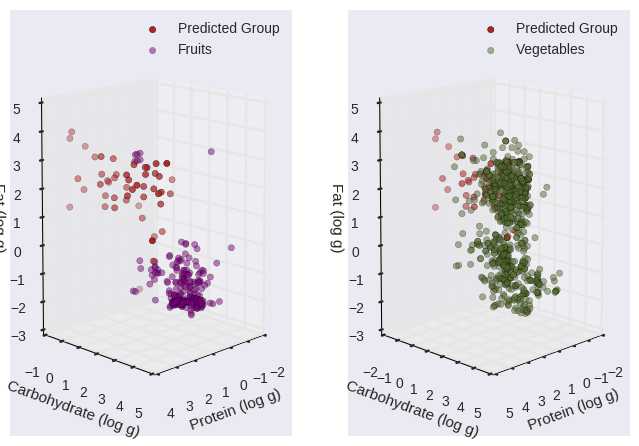

In [28]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

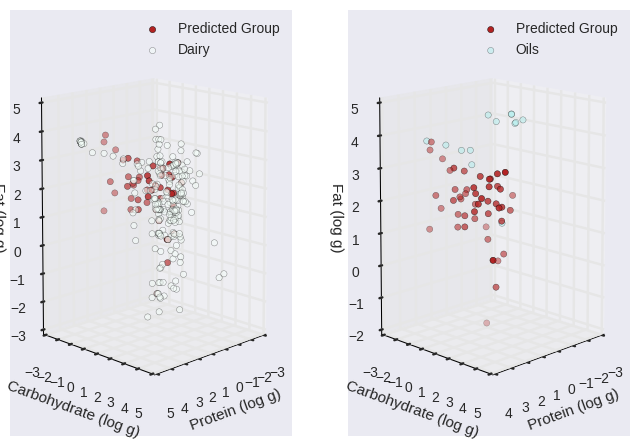

In [29]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

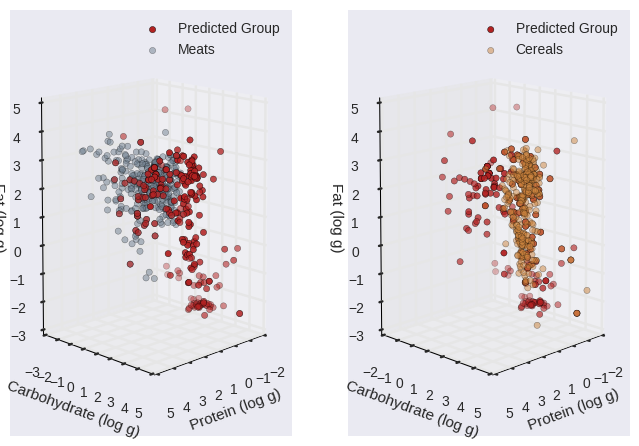

In [30]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

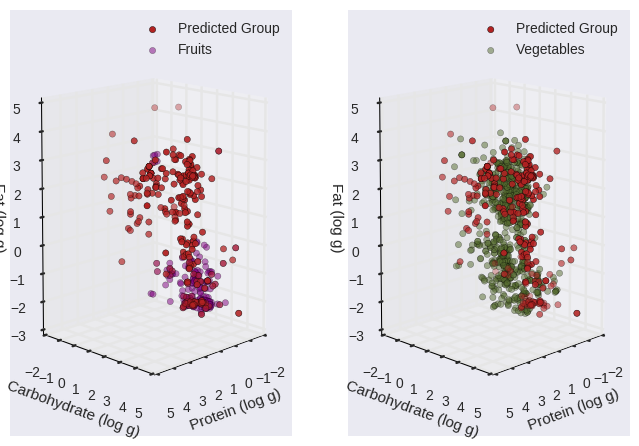

In [31]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

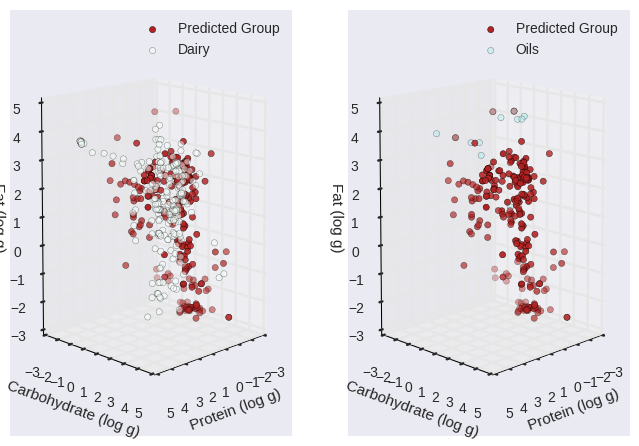

In [32]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

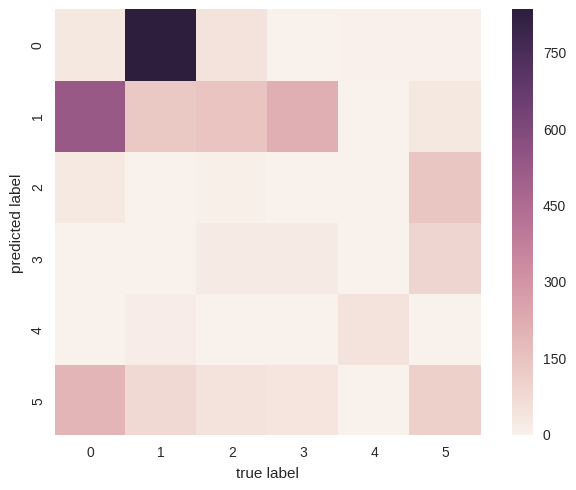

In [33]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(all_these.Label, predicted_labels)
sns.heatmap(mat.T, square=True)
plt.xlabel('true label')
plt.ylabel('predicted label')